In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import pickle
import os
import h5py
import collections as cl
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import random
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from deem import deem

In [2]:
param_grid = {'LR_param': {'C':[10**k for k in range(-10, 6, 2)]}, 'scoring': 'roc_auc', 'cv': 3, 'random_state': 42}

with open("genre_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    genre_map = json.load(f)
aligned_genre = list(genre_map)[:-1]

with open("instrument_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    instrument_map = json.load(f)

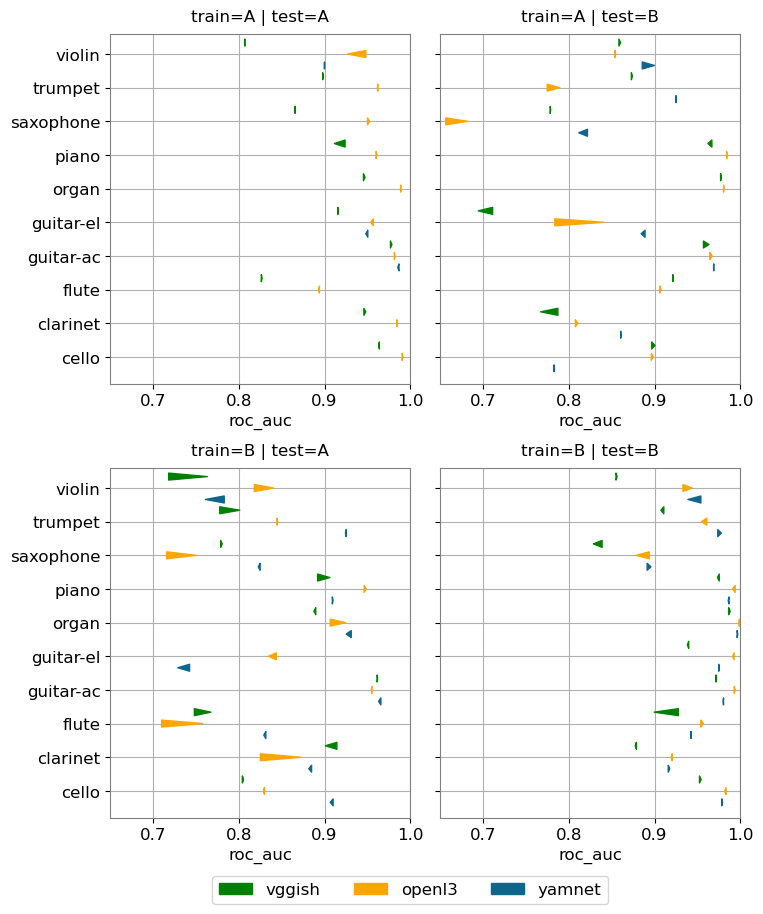

In [3]:
from matplotlib.markers import MarkerStyle
import matplotlib.patches as mpatches

def plot(ax, train_set, test_set, df, lir_nonlir):

    df_visual1 = df[df['train_set']==train_set]
    df = df_visual1[df_visual1['test_set']==test_set]
    
    dist = 1
    ms1 = 20 # marker size
    line_alpha = .6; linewidth = 2
    marker_alpha = .8

    embedding_color = [('vggish', 'green'), ('openl3', 'orange'), ('yamnet', '#0e668b')]
    y_mebedding = {'vggish': np.arange(len(instrument_map)) * 5 + 1.7,
                   'openl3': np.arange(len(instrument_map)) * 5,
                   'yamnet': np.arange(len(instrument_map)) * 5 - 1.7}
           
    for embedding, color in embedding_color:
        y = y_mebedding[embedding]
        if lir_nonlir == 'linear':
            bias_lir_nonlir = [embedding, embedding+'-lda']
        else:
            bias_lir_nonlir = [embedding+'-k', embedding+'-klda', embedding+'-klda-genre']      
            
        x = list(df[df['embedding']==bias_lir_nonlir[1]][metric])
#         ax.scatter(y=y, x=x, alpha=.8, color=color, marker='.', s=ms1, label=embedding)
        for mark in range(len(y)):
            ax.annotate('', (x[mark], y[mark]), 
                    xytext=(list(df[df['embedding']==bias_lir_nonlir[0]][metric])[mark], y[mark]), 
                        arrowprops = dict(arrowstyle="wedge,tail_width=.5", alpha=1, color=color, edgecolor=color))

#         y = y - dist
#         x = list(df[df['embedding']==bias_lir_nonlir[2]][metric])
# #         ax.scatter(y=y, x=x, alpha=.8, color=color, marker='.', s=ms1, label=embedding)
#         for mark in range(len(y)):
#             ax.annotate('', (x[mark], y[mark]), 
#                     xytext=(list(df[df['embedding']==bias_lir_nonlir[0]][metric])[mark], y[mark]), 
#                         arrowprops = dict(arrowstyle="wedge,tail_width=.5", alpha=1, color=color, edgecolor=color))

    ax.set_title('train='+train_set+' | '+'test='+test_set)
    ax.set_yticks(np.arange(len(instrument_map)) * 5)
    ax.set_yticklabels(list(instrument_map.keys())) 
    ax.set_xlabel('roc_auc')
    
df = pd.read_csv('results/result_all_lda.csv')
metric = 'roc_auc'
figure = plt.figure(figsize=(6,7))

size = 12
params = {'legend.fontsize': size,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.edgecolor': 'grey',
          'axes.titlepad': size*.75}
plt.rcParams.update(params)

train_set = 'B'; test_set = 'A'
ax = plt.Axes(figure, [0, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_ylim([-4,48])

# Creating legend with color box
patch1 = mpatches.Patch(color='green', label='vggish')
patch2 = mpatches.Patch(color='orange', label='openl3')
patch3 = mpatches.Patch(color='#0e668b', label='yamnet')
plt.legend(handles=[patch1, patch2, patch3], loc="lower center", ncol=3, bbox_to_anchor=(1, -0.27))
plt.grid(True)

train_set = 'B'; test_set = 'B'; 
ax = plt.Axes(figure, [0.5+.05, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])
plt.grid(True)

train_set = 'A'; test_set = 'A'; 
ax = plt.Axes(figure, [0, 0.5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_ylim([-4,48]); 
plt.grid(True)

train_set = 'A'; test_set = 'B'; 
ax = plt.Axes(figure, [.5+.05, .5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])
plt.grid(True)

plt.tight_layout(); 
# plt.savefig('results/crossdataset_allresults.pdf', bbox_inches = "tight"); 
plt.savefig('results/irmas_only_lda.pdf', bbox_inches = "tight")

## statistics

In [9]:
df1 = pd.read_csv('results/result_vggish-lda.csv')
df2 = pd.read_csv('results/result_openl3-lda.csv')
df3 = pd.read_csv('results/result_yamnet-lda.csv')
df = df1.append(df2).append(df3)
df

,instrument,train_set,test_set,precision,recall,f1-score,support,accuracy,roc_auc,ap,embedding
0,cello,A,A,0.243243,0.900000,0.382979,30.0,0.885224,0.963965,0.650031,vggish
1,clarinet,A,A,0.291667,0.800000,0.427481,35.0,0.901055,0.942660,0.525969,vggish
2,flute,A,A,0.250000,0.636364,0.358974,44.0,0.868074,0.826267,0.527185,vggish
3,guitar-ac,A,A,0.609589,0.908163,0.729508,98.0,0.912929,0.976948,0.898427,vggish
4,guitar-el,A,A,0.512438,0.792308,0.622356,130.0,0.835092,0.912359,0.763659,vggish
...,...,...,...,...,...,...,...,...,...,...,...
83,piano,B,A,0.409836,0.641026,0.500000,39.0,0.934037,0.909846,0.602181,yamnet-lda
84,saxophone,B,A,0.339623,0.514286,0.409091,35.0,0.931398,0.822723,0.334405,yamnet-lda
85,trumpet,B,A,0.441176,0.731707,0.550459,41.0,0.935356,0.924414,0.688023,yamnet-lda
86,violin,B,A,0.309524,0.282609,0.295455,46.0,0.918206,0.757786,0.279967,yamnet-lda


In [10]:
df.to_csv('results/result_all_lda.csv', index=False)

In [69]:
embeddings = ['vggish', 'openl3', 'yamnet', 'vggish-lda', 'openl3-lda', 'yamnet-lda']

case_mean_all = pd.DataFrame(columns=['embedding', 'train_set', 'test_set', 'mean', 'change'])

cases = [['A', 'A'], ['B', 'B'], ['B', 'A'], ['A', 'B']]
for embedding in embeddings:
    for case in cases:
        train_set = case[0]
        test_set = case[1]
        case_mean = df.loc[(df['train_set'] == train_set) & (df['test_set'] == test_set) 
                        & (df['embedding'] == embedding)]['roc_auc'].values.mean()
        
        case_mean_item = pd.DataFrame(columns=['embedding', 'train_set', 'test_set', 'mean', 'change'])
        case_mean_item['embedding'] = [embedding]
        case_mean_item['train_set'] = [train_set]
        case_mean_item['test_set'] = [test_set]
        case_mean_item['mean'] = [case_mean]

        case_mean_all = case_mean_all.append(case_mean_item)
        # print('{}: {} -> {}, mean = {}'.format(embedding, train_set, test_set, case_mean))

In [70]:
case_mean_all

,embedding,train_set,test_set,mean,change
0,vggish,A,A,0.913094,NaN
0,vggish,B,B,0.931541,NaN
0,vggish,B,A,0.823639,NaN
0,vggish,A,B,0.881214,NaN
0,openl3,A,A,0.964773,NaN
0,openl3,B,B,0.965909,NaN
0,openl3,B,A,0.849173,NaN
0,openl3,A,B,0.870904,NaN
0,yamnet,A,A,0.94716,NaN
0,yamnet,B,B,0.962883,NaN


In [71]:
for embedding in ['vggish', 'openl3', 'yamnet']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'B') & (case_mean_all['test_set'] == 'A'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'B') & (case_mean_all['test_set'] == 'A')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'A') & (case_mean_all['test_set'] == 'A')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'A') & (case_mean_all['test_set'] == 'B'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'A') & (case_mean_all['test_set'] == 'B')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'B') & (case_mean_all['test_set'] == 'B')]['mean']

In [72]:
for embedding in ['vggish-lda', 'openl3-lda', 'yamnet-lda']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'B') & (case_mean_all['test_set'] == 'A'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &  # debiased
                        (case_mean_all['train_set'] == 'B') & (case_mean_all['test_set'] == 'A')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-lda','')) &  # original 
                        (case_mean_all['train_set'] == 'B') & (case_mean_all['test_set'] == 'A')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'A') & (case_mean_all['test_set'] == 'B'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &   # debiased
                        (case_mean_all['train_set'] == 'A') & (case_mean_all['test_set'] == 'B')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-lda','')) & # original 
                        (case_mean_all['train_set'] == 'A') & (case_mean_all['test_set'] == 'B')]['mean']

In [73]:
case_mean_all

,embedding,train_set,test_set,mean,change
0,vggish,A,A,0.913094,NaN
0,vggish,B,B,0.931541,NaN
0,vggish,B,A,0.823639,-0.089456
0,vggish,A,B,0.881214,-0.050327
0,openl3,A,A,0.964773,NaN
0,openl3,B,B,0.965909,NaN
0,openl3,B,A,0.849173,-0.1156
0,openl3,A,B,0.870904,-0.095005
0,yamnet,A,A,0.94716,NaN
0,yamnet,B,B,0.962883,NaN


In [74]:
for embedding in ['vggish', 'openl3', 'yamnet']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))

vggish, mean: [0.9130942846643726, 0.9315406604200653, 0.8236386359294425, 0.8812139224146861], change: [nan, nan, -0.08945564873493006, -0.050326738005379235]
openl3, mean: [0.9647727850502844, 0.9659090129304733, 0.8491727724930407, 0.8709042409200081], change: [nan, nan, -0.11560001255724373, -0.0950047720104652]
yamnet, mean: [0.9471603192461665, 0.9628828765410501, 0.8822809928058714, 0.9109391691350794], change: [nan, nan, -0.06487932644029515, -0.05194370740597065]


In [75]:
for embedding in ['vggish-lda', 'openl3-lda', 'yamnet-lda']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))

vggish-lda, mean: [0.9118412567322379, 0.9259992679975189, 0.8358957798209485, 0.8766393602500154], change: [nan, nan, 0.012257143891506006, -0.00457456216467067]
openl3-lda, mean: [0.9617193481286491, 0.9646300620389439, 0.86674584312226, 0.8849179050648704], change: [nan, nan, 0.01757307062921931, 0.014013664144862381]
yamnet-lda, mean: [0.9472743933530077, 0.9631365606113662, 0.8731132322656272, 0.9102603078438457], change: [nan, nan, -0.009167760540244152, -0.0006788612912337344]


## in-domain performance

In [76]:
debias_method = ''
indomain_performance = pd.DataFrame(columns=['instrument', 'test set', 'embedding', 'in-domain performance'])

for embedding in ['vggish', 'openl3', 'yamnet']:

    df = pd.read_csv('results/result_' + embedding +  debias_method + '.csv')
    A_drop = df.loc[(df['train_set'] == 'A') & (df['test_set'] == 'A')]['roc_auc'].values

    B_drop = df.loc[(df['train_set'] == 'B') & (df['test_set'] == 'B')]['roc_auc'].values

    item_drop = pd.DataFrame(columns=['instrument', 'test set', 'embedding', 'in-domain performance'])
    item_drop['instrument'] = list(instrument_map) * 2
    item_drop['test set'] = ['A'] * len(instrument_map) + ['B'] * len(instrument_map)
    item_drop['embedding'] = [embedding] * len(instrument_map) * 2
    item_drop['in-domain performance'] = list(A_drop) + list(B_drop)

    indomain_performance = indomain_performance.append(item_drop)

FileNotFoundError: [Errno 2] No such file or directory: 'results/result_vggish.csv'

In [77]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.6)
colors = ['green', 'orange', '#0e668b']
hue_order = ['vggish', 'openl3', 'yamnet']
    
df = indomain_performance
ax = sns.catplot(data=df, col='test set', x='instrument', y='in-domain performance', hue='embedding', kind='bar', aspect=2, 
               legend_out=False, palette=colors, hue_order=hue_order, alpha = 0.8)
a0 = ax.fig.axes[0]
a0.set_title("(a) train = A | test = A")
a0.set_ylim([.8,1])
handles, labels = a0.get_legend_handles_labels()
df_A = df[df['test set']=='A']
text = [a0.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_A[df_A['embedding']==hue_order[l]]['in-domain performance'].mean(), 3)) + ')' for l in range(len(hue_order))]
a0.legend(handles, text)
lgd = sns.move_legend(a0, "lower center", bbox_to_anchor=(.5, -.47), ncol=3, title=None, frameon=False)

a1 = ax.fig.axes[1]
a1.set_title("(b) train = B | test = B")
a1.set_ylim([.8,1])
handles, labels = a1.get_legend_handles_labels()
df_B = df[df['test set']=='B']
text = [a1.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_B[df_B['embedding']==hue_order[l]]['in-domain performance'].mean(), 3)) + ')' for l in range(len(hue_order))]
a1.legend(handles, text)
lgd = sns.move_legend(a1, "lower center", bbox_to_anchor=(.5, -.47), ncol=3, title=None, frameon=False)

ax.set(xlabel=None)
plt.subplots_adjust(wspace=0.15)
ax.set_xticklabels(rotation=30)

plt.savefig('results/indomain_performance.pdf', bbox_inches='tight')
# plt.savefig('results/cosine_similarity.png', bbox_inches='tight')

ValueError: Number of columns must be a positive integer, not 0

<Figure size 0x500 with 0 Axes>

## cross-domain before debiasing

In [88]:
crossdomain_performance = pd.DataFrame(columns=['instrument', 'test set', 'embedding', 'cross-domain performance'])

for embedding in ['vggish', 'openl3', 'yamnet']:

    df = pd.read_csv('results/result_' + embedding +  debias_method + '.csv')
    A_drop = df.loc[(df['train_set'] == 'B') & (df['test_set'] == 'A')]['roc_auc'].values

    B_drop = df.loc[(df['train_set'] == 'A') & (df['test_set'] == 'B')]['roc_auc'].values

    item_drop = pd.DataFrame(columns=['instrument', 'test set', 'embedding', 'cross-domain performance'])
    item_drop['instrument'] = list(instrument_map) * 2
    item_drop['test set'] = ['A'] * len(instrument_map) + ['B'] * len(instrument_map)
    item_drop['embedding'] = [embedding] * len(instrument_map) * 2
    item_drop['cross-domain performance'] = list(A_drop) + list(B_drop)

    crossdomain_performance = crossdomain_performance.append(item_drop)

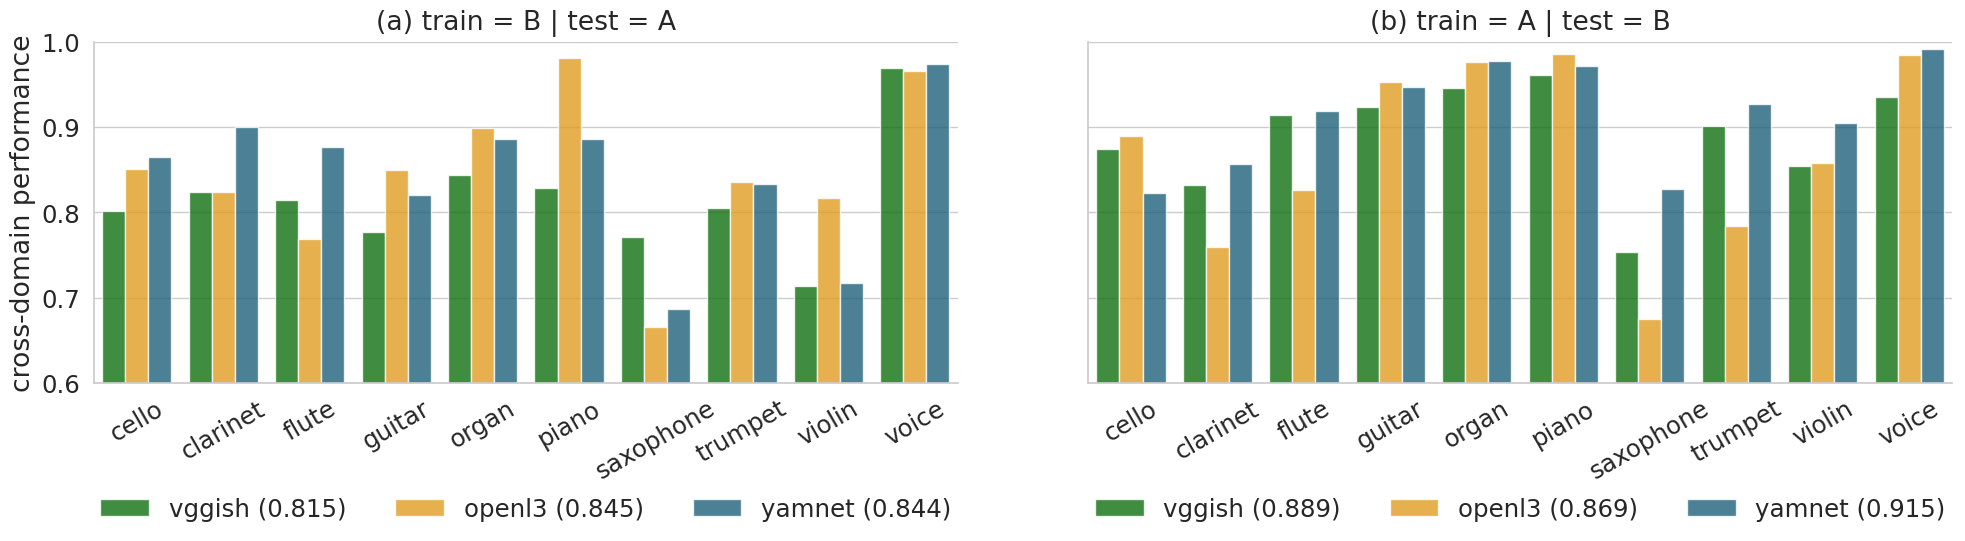

In [89]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.6)
colors = ['green', 'orange', '#0e668b']
hue_order = ['vggish', 'openl3', 'yamnet']
    
df = crossdomain_performance
ax = sns.catplot(data=df, col='test set', x='instrument', y='cross-domain performance', hue='embedding', kind='bar', aspect=2, 
               legend_out=False, palette=colors, hue_order=hue_order, alpha = 0.8)
a0 = ax.fig.axes[0]
a0.set_title("(a) train = B | test = A")
a0.set_ylim([.6,1])
handles, labels = a0.get_legend_handles_labels()
df_A = df[df['test set']=='A']
text = [a0.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_A[df_A['embedding']==hue_order[l]]['cross-domain performance'].mean(), 3)) + ')' for l in range(len(hue_order))]
a0.legend(handles, text)
lgd = sns.move_legend(a0, "lower center", bbox_to_anchor=(.5, -.47), ncol=3, title=None, frameon=False)

a1 = ax.fig.axes[1]
a1.set_title("(b) train = A | test = B")
a1.set_ylim([.6,1])
handles, labels = a1.get_legend_handles_labels()
df_B = df[df['test set']=='B']
text = [a1.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_B[df_B['embedding']==hue_order[l]]['cross-domain performance'].mean(), 3)) + ')' for l in range(len(hue_order))]
a1.legend(handles, text)
lgd = sns.move_legend(a1, "lower center", bbox_to_anchor=(.5, -.47), ncol=3, title=None, frameon=False)

ax.set(xlabel=None)
plt.subplots_adjust(wspace=0.15)
ax.set_xticklabels(rotation=30)

plt.savefig('results/crossdomain_performance_before.pdf', bbox_inches='tight')
# plt.savefig('results/cosine_similarity.png', bbox_inches='tight')

## cross-domain after debiasing

In [90]:
crossdomain_performance = pd.DataFrame(columns=['instrument', 'test set', 'embedding', 'cross-domain performance'])
debias_method = '-lda'

for embedding in ['vggish', 'openl3', 'yamnet']:

    df = pd.read_csv('results/result_' + embedding +  debias_method + '.csv')
    A_drop = df.loc[(df['train_set'] == 'B') & (df['test_set'] == 'A') & 
                    (df['embedding'] == embedding +  debias_method)]['roc_auc'].values

    B_drop = df.loc[(df['train_set'] == 'A') & (df['test_set'] == 'B')& 
                    (df['embedding'] == embedding +  debias_method)]['roc_auc'].values

    item_drop = pd.DataFrame(columns=['instrument', 'test set', 'embedding', 'cross-domain performance'])
    item_drop['instrument'] = list(instrument_map) * 2
    item_drop['test set'] = ['A'] * len(instrument_map) + ['B'] * len(instrument_map)
    item_drop['embedding'] = [embedding] * len(instrument_map) * 2
    item_drop['cross-domain performance'] = list(A_drop) + list(B_drop)

    crossdomain_performance = crossdomain_performance.append(item_drop)

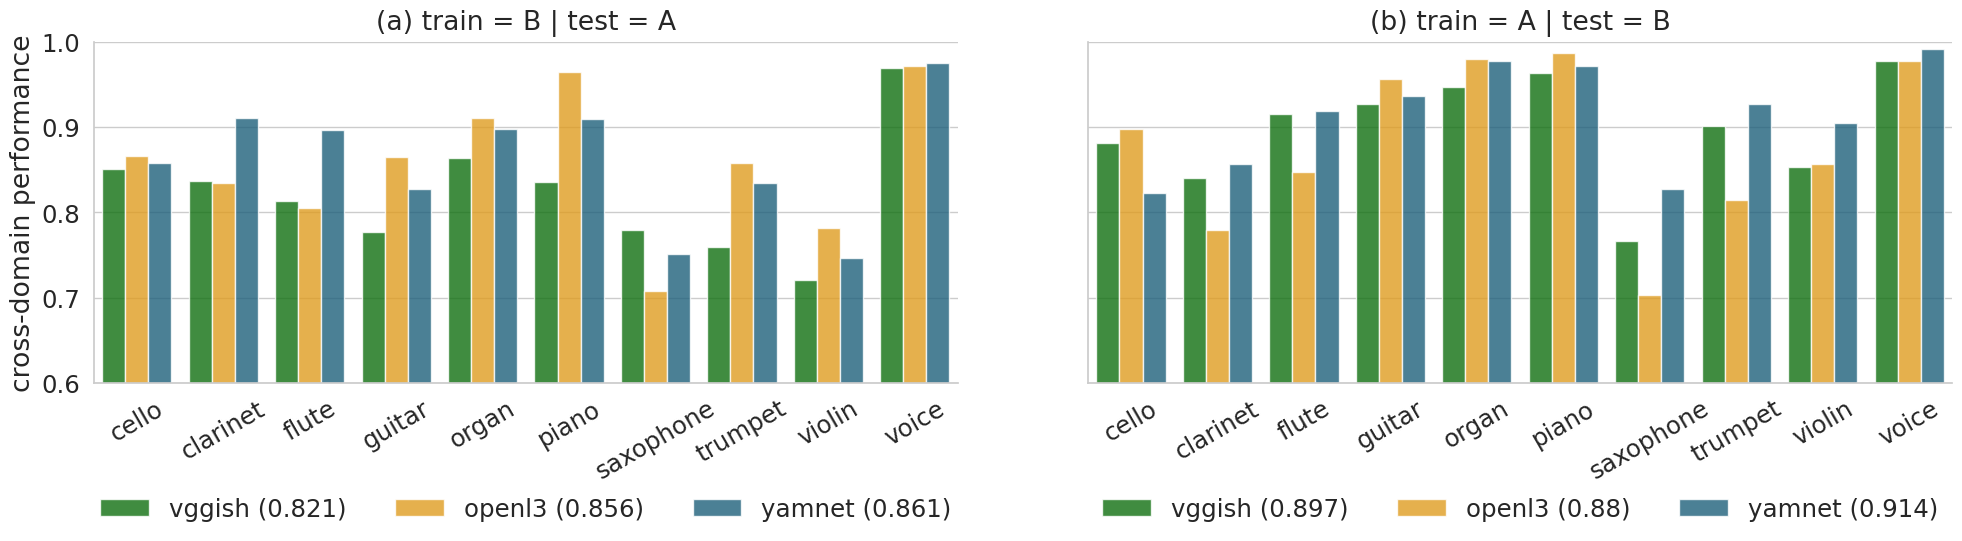

In [91]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.6)
colors = ['green', 'orange', '#0e668b']
hue_order = ['vggish', 'openl3', 'yamnet']
    
df = crossdomain_performance
ax = sns.catplot(data=df, col='test set', x='instrument', y='cross-domain performance', hue='embedding', kind='bar', aspect=2, 
               legend_out=False, palette=colors, hue_order=hue_order, alpha = 0.8)
a0 = ax.fig.axes[0]
a0.set_title("(a) train = B | test = A")
a0.set_ylim([.6,1])
handles, labels = a0.get_legend_handles_labels()
df_A = df[df['test set']=='A']
text = [a0.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_A[df_A['embedding']==hue_order[l]]['cross-domain performance'].mean(), 3)) + ')' for l in range(len(hue_order))]
a0.legend(handles, text)
lgd = sns.move_legend(a0, "lower center", bbox_to_anchor=(.5, -.47), ncol=3, title=None, frameon=False)

a1 = ax.fig.axes[1]
a1.set_title("(b) train = A | test = B")
a1.set_ylim([.6,1])
handles, labels = a1.get_legend_handles_labels()
df_B = df[df['test set']=='B']
text = [a1.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_B[df_B['embedding']==hue_order[l]]['cross-domain performance'].mean(), 3)) + ')' for l in range(len(hue_order))]
a1.legend(handles, text)
lgd = sns.move_legend(a1, "lower center", bbox_to_anchor=(.5, -.47), ncol=3, title=None, frameon=False)

ax.set(xlabel=None)
plt.subplots_adjust(wspace=0.15)
ax.set_xticklabels(rotation=30)

plt.savefig('results/crossdomain_performance_lda.pdf', bbox_inches='tight')
# plt.savefig('results/cosine_similarity.png', bbox_inches='tight')